### Topic Analysis using LDA Topic Model (Community Dataset #1: 01/09/2020 - 15/12/2020)

#### Import core libraries

In [1]:
# Import Core library
import sys
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt, nltk, datetime as dt, seaborn as sns
import emoji
import little_mallet_wrapper
import plotly.express as px
import wordcloud
import openpyxl
from pprint import pprint
from cleantext import clean

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
[nltk_data] Downloading package stopwords to C:\Users\Ivory-
[nltk_data]     UALR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Import Dataset

In [2]:
# Import Dataset
df = pd.read_excel('../Community306_raw.xlsx')

In [ ]:
# view column titles of dataset
df.columns

In [8]:
df['create_year'] = pd.to_datetime(df.created_at, format='%m/%d/%Y', errors='coerce')
df['year'] = pd.to_datetime(df.created_at).dt.strftime('%Y')
df['month'] = pd.to_datetime(df.created_at).dt.strftime('%m')

start_date = "09/01/2020"
end_date = "12/15/2020"
after_start_date = df['create_year'] > start_date
before_end_date = df['create_year'] < end_date
between_two_dates = after_start_date & before_end_date

stream_one = df.loc[between_two_dates]

In [9]:
# stream_one.to_excel(r"C:\Users\Ivory-UALR\Documents\COSMOS\Billy's Project\community_topic_model\1st_community_dataset_3262022\1st_analysis_LDAmodel\stream_one.xlsx")

#### Process Dataset

In [12]:
# Function to remove twitter specific characters
def get_url_patern():
    return re.compile(
        r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))'
        r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})')

def get_hashtags_pattern():
    return re.compile(r'#\w*')

def get_single_letter_words_pattern():
    return re.compile(r'(?<![\w\-])\w(?![\w\-])')

def get_blank_spaces_pattern():
    return re.compile(r'\s{2,}|\t')

def get_twitter_reserved_words_pattern():
    return re.compile(r'(RT|rt|FAV|fav|VIA|via)')

def get_mentions_pattern():
    return re.compile(r'@\w*')

def process_text(word):
  word=re.sub(pattern=get_url_patern(), repl="", string=word)
  word=re.sub(pattern=get_mentions_pattern(), repl="", string=word)
  word=re.sub(pattern=get_hashtags_pattern(), repl="", string=word)
  word=re.sub(pattern=get_twitter_reserved_words_pattern(), repl='', string=word)
  word=re.sub(r'http\S+', "", word)  # remove http links
  word=re.sub(r'bit.ly/\S+', "", word)  # rempve bitly links
  word=word.strip('[link]')  # remove [links]
  word=re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', "", word)  # remove retweet
  word=re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', "", word)  # remove tweeted at
  word=word.encode('ascii', 'ignore').decode('ascii')
#   word=clean(word, no_emoji=True)
  return word

<>:30: DeprecationWarning: invalid escape sequence \s
<>:30: DeprecationWarning: invalid escape sequence \s
C:\Users\IVORY-~1\AppData\Local\Temp/ipykernel_20392/758640023.py:30: DeprecationWarning: invalid escape sequence \s
  word=re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', "", word)  # remove retweet


In [ ]:
# Remove twitter specific characters
stream_one.text = stream_one.apply(lambda row: process_text(row.text), 1)

In [22]:
# Remove punctuations, stop words, digits and turn text to lowercase
training_data = list(set(little_mallet_wrapper.process_string(text, numbers='remove') for text in stream_one.text))
data = training_data
data[:5]

['',
 'thank service thank joining ranks fight keep freedom vote keeping honest petition government without undue burden public forum twitter applies open social media',
 'aliens yes question',
 'half people think america woh saving operation get updates stay tuned marching orders',
 'god bless wood']

In [23]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:10])

[[], ['thank', 'service', 'thank', 'joining', 'ranks', 'fight', 'keep', 'freedom', 'vote', 'keeping', 'honest', 'petition', 'government', 'without', 'undue', 'burden', 'public', 'forum', 'twitter', 'applies', 'open', 'social', 'media'], ['aliens', 'yes', 'question'], ['half', 'people', 'think', 'america', 'woh', 'saving', 'operation', 'get', 'updates', 'stay', 'tuned', 'marching', 'orders'], ['god', 'bless', 'wood'], ['latest', 'sylvie', 'laflamme', 'journal', 'thanks'], ['thankful', 'family', 'maga', 'friends', 'president'], ['federal', 'cou', 'fast', 'tracking', 'request', 'forensic', 'exam', 'voting', 'machines'], ['dont', 'right', 'right', 'never', 'another', 'honest', 'election', 'country'], ['wow', 'wow', 'wow', 'best', 'video', 'sidney', 'powell', 'voter', 'fraud']]


#### N-grams & Lemmatization

In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [25]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [26]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.max_length = 40000000

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [27]:
print(data_lemmatized[:10])

[[], ['thank', 'service', 'thank', 'join', 'rank', 'fight', 'keep', 'freedom', 'vote', 'keep', 'honest', 'petition', 'government', 'undue', 'burden', 'public', 'forum', 'twitter', 'apply', 'open', 'social_media'], ['alien', 'question'], ['half', 'people', 'think', 'save', 'operation', 'get', 'update', 'stay_tune', 'marching_order'], ['god_bless', 'wood'], ['late', 'sylvie', 'laflamme', 'journal', 'thank'], ['thankful', 'family', 'friend', 'president'], ['federal', 'cou', 'fast', 'tracking', 'request', 'forensic', 'exam', 'voting_machine'], ['right', 'right', 'never', 'honest', 'election', 'country'], ['good', 'video', 'voter', 'fraud']]


In [28]:
# Export lemmatized data for document similarity evaluation
corpus_df = pd.DataFrame(data_lemmatized)
corpus_df.to_csv('master_corpus_no_duplicate.csv', index=False, header=False)

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[], [], [], [(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)], [(15, 1), (16, 1)], [(17, 2), (18, 1), (19, 1), (20, 1)], [(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2)], [], [(15, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1)], [(15, 1), (37, 1), (40, 1), (43, 1), (44, 1)]]


#### Building the LDA Model

In [40]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           iterations=50,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [41]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.261727239631975

Coherence Score:  0.2877000733405275


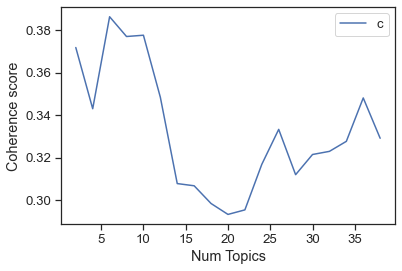

In [42]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=2)

# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [45]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
# NB: From pyLDAvis visualization, optimal number of topics is 10

Num Topics = 2  has Coherence Value of 0.3718
Num Topics = 4  has Coherence Value of 0.343
Num Topics = 6  has Coherence Value of 0.3863
Num Topics = 8  has Coherence Value of 0.377
Num Topics = 10  has Coherence Value of 0.3776
Num Topics = 12  has Coherence Value of 0.3484
Num Topics = 14  has Coherence Value of 0.3077
Num Topics = 16  has Coherence Value of 0.3067
Num Topics = 18  has Coherence Value of 0.2983
Num Topics = 20  has Coherence Value of 0.2932
Num Topics = 22  has Coherence Value of 0.2953
Num Topics = 24  has Coherence Value of 0.3168
Num Topics = 26  has Coherence Value of 0.3333
Num Topics = 28  has Coherence Value of 0.3119
Num Topics = 30  has Coherence Value of 0.3214
Num Topics = 32  has Coherence Value of 0.3229
Num Topics = 34  has Coherence Value of 0.3276
Num Topics = 36  has Coherence Value of 0.3481
Num Topics = 38  has Coherence Value of 0.3291


In [46]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.064*"fight" + 0.042*"need" + 0.032*"see" + 0.030*"say" + 0.029*"go" + '
  '0.028*"keep" + 0.028*"give" + 0.025*"hear" + 0.025*"country" + '
  '0.020*"love"'),
 (1,
  '0.141*"never" + 0.091*"watch" + 0.056*"demand" + 0.053*"video" + '
  '0.043*"believe" + 0.032*"ever" + 0.031*"cast" + 0.030*"folk" + '
  '0.020*"governor" + 0.019*"share"'),
 (2,
  '0.100*"want" + 0.069*"call" + 0.059*"machine" + 0.048*"look" + 0.036*"news" '
  '+ 0.031*"fix" + 0.029*"really" + 0.019*"rig" + 0.017*"forward" + '
  '0.016*"impoant"'),
 (3,
  '0.116*"people" + 0.092*"president" + 0.062*"right" + 0.055*"thank" + '
  '0.036*"come" + 0.032*"integrity" + 0.023*"truth" + 0.022*"make" + '
  '0.022*"work" + 0.021*"american"'),
 (4,
  '0.078*"suppo" + 0.069*"join" + 0.044*"accept" + 0.040*"help" + 0.033*"barr" '
  '+ 0.023*"republican" + 0.023*"continue" + 0.021*"hearing" + 0.018*"job" + '
  '0.017*"texas_lawsuit"'),
 (5,
  '0.053*"take" + 0.052*"know" + 0.049*"live" + 0.039*"sign_petition" + '
  '0.035*"e

#### Visualize Topic Distribution & Keywords

In [47]:
topic_dist = pd.DataFrame()

# Code to view the Ist 4 keywords per topic
for index, topic in lda_model.show_topics(formatted=False, num_words= 10):
    words = [w[0] for w in topic]
    topic_distributions_df = ["".join(topic[:4]) for topic in words]
    topic_dist = topic_dist.append(pd.Series([index, words]), ignore_index=True)
    
    # print('Topic: {} \nWords: {}'.format(index, words))
    # print(topic_distributions_df)
    
topic_dist.columns = ['Topic_Number', 'Topic_Words']
# Export topic word distribution per topic to excel file
topic_dist.to_excel(r"C:\Users\Ivory-UALR\Documents\COSMOS\Billy's Project\community_topic_model\1st_community_dataset\1st_analysis_LDAmodel\1st_analysis_LDA_topic_words(8_topics).xlsx", index=False, header=True)

In [25]:
topic_dist

,Topic_Number,Topic_Words
0,0.0,"[trump, give, see, biden, time, let, watch, th..."
1,1.0,"[thank, stand, patriot, freedom, sign_petition..."
2,2.0,"[get, dominion, happen, evidence, com, true, a..."
3,3.0,"[still, right, ballot, voting, show, result, a..."
4,4.0,"[people, take, love, demand, back, lose, barr,..."
5,5.0,"[vote, know, say, stop, machine, read, want, c..."
6,6.0,"[audit, pay, elector, great, news, help, hones..."
7,7.0,"[live, march_washingto, rally, home, good, che..."
8,8.0,"[election, fight, steal, president, never, nee..."
9,9.0,"[fraud, state, voter, country, today, make, in..."


In [48]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\Ivory-UALR\AppData\Local\Programs\Python\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.103500  0.388677       1        1  19.239140
6     -0.251424 -0.208797       2        1  18.151159
0     -0.070628  0.020159       3        1  14.354966
4      0.300626 -0.008702       4        1  12.954380
3      0.173657 -0.017116       5        1  11.235237
2      0.075919 -0.132373       6        1  10.649975
7     -0.103258 -0.047615       7        1   7.453224
1     -0.021392  0.005767       8        1   5.961919, topic_info=          Term          Freq         Total Category  logprob  loglift
17    election  26807.000000  26807.000000  Default  30.0000  30.0000
33        vote  15971.000000  15971.000000  Default  29.0000  29.0000
151      fraud  15011.000000  15011.000000  Default  28.0000  28.0000
276      fight  11294.000000  11294.000000  Default  27.0000  27.0000
266       live   9241.000000   9241.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
562       open    484.775921    485.658231   Topic8  -4.7153   2.8180
158       file    460.640215    461.521576   Topic8  -4.7663   2.8179
907       feel    434.920415    435.801914   Topic8  -4.8238   2.8178
422        buy    368.544742    369.426418   Topic8  -4.9894   2.8174
1848    entire    291.890801    292.772515   Topic8  -5.2226   2.8168

[277 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
820       2  0.999750  accept
45        6  0.998867     act
399       3  0.999186  action
149       3  0.998303   agree
274       8  0.998595     ali
...     ...       ...     ...
128       2  0.999402     win
43        1  0.999614    work
747       6  0.999226   world
91        2  0.999751    year
218       5  0.998165     yet

[284 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 1, 5, 4, 3, 8, 2])

In [50]:
# Export LDA Model
pyLDAvis.save_html(vis, r"C:\Users\Ivory-UALR\Documents\COSMOS\Billy's Project\community_topic_model\1st_community_dataset\1st_analysis_LDAmodel\1st_analysis_lda_vis(08_topics).html")

#### Visualize Topic Distribution (Dominant topic per text, Topic distribution over time (Topic Stream))

In [51]:
# View dominant topic per document (tweet) and topic percent contribution per tweet
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.1894,"people, voter, never, say, need, still, ballot...",
1,1,5.0,0.1894,"people, voter, never, say, need, still, ballot...",
2,2,5.0,0.1894,"people, voter, never, say, need, still, ballot...",
3,3,4.0,0.2772,"state, take, today, machine, demand, citizen, ...",time end cashless bail stupid bail reform turn...
4,4,5.0,0.1809,"people, voter, never, say, need, still, ballot...",thing test run
5,5,6.0,0.2589,"election, steal, president, stand, go, day, su...",steal election election tactic used test run
6,6,2.0,0.2675,"know, thank, country, dominion, let, love, hap...",true know vote primaries got congress votes de...
7,7,5.0,0.1894,"people, voter, never, say, need, still, ballot...",
8,8,5.0,0.2724,"people, voter, never, say, need, still, ballot...",test run worked like charm prevented broward c...
9,9,5.0,0.2586,"people, voter, never, say, need, still, ballot...",test run worked like charm prevented broward c...


#### Visualize topic stream by Month

In [ ]:
# Add year column to topic distribution dataset
dates = pd.Series(stream_one['create_year'])
topic_dist = pd.concat([df_dominant_topic, dates], axis=1)
# Drop NaN rows
topic_dist.dropna()

# Group Dataframe by year and aggregate by count() (over months)
topic_dist['create_year'] = pd.to_datetime(topic_dist['create_year'])
topic_dist_count = topic_dist.groupby(['Dominant_Topic', pd.Grouper(key='create_year', freq='M')])['Dominant_Topic'].agg(['count']).reset_index()
print(topic_dist_count)

# return a sorted DataFrame by date then count
topic_dist_count = topic_dist_count.sort_values(by=['create_year', 'count'])
# reset the index
topic_dist_count = topic_dist_count.reset_index(drop=True)

In [30]:
# df_dominant_topic[df_dominant_topic.Dominant_Topic == 7.0]
topic_dist_count.columns

Index(['Dominant_Topic', 'create_year', 'count'], dtype='object')

In [31]:
# Plot topic distribution over time
topic_stream = px.area(topic_dist_count, x='create_year', y='count', color='Dominant_Topic')
topic_stream

In [32]:
# Export topic stream plot
topic_stream.write_html(r"C:\Users\Ivory-UALR\Documents\COSMOS\Billy's Project\community_topic_model\1st_community_dataset_3262022\1st_analysis_LDAmodel\1st_analysis_topicstream_vis.html")

In [33]:
topic_dist.dtypes

Document_No                  float64
Dominant_Topic               float64
Topic_Perc_Contrib           float32
Keywords                      object
Text                          object
create_year           datetime64[ns]
dtype: object

#### Visualize topic streams by weeks

In [36]:
# Add year column to topic_dist_week distribution dataset
dates = pd.Series(stream_one['create_year'])
topic_dist_week = pd.concat([df_dominant_topic, dates], axis=1)

# Drop NaN rows
topic_dist_week = topic_dist_week.dropna()

# Add a year column to the topic_dist_week dataframe
topic_dist_week['year'] = pd.to_datetime(topic_dist_week.create_year).dt.strftime('%Y')

# Add a week_number column to the topic_dist_week dataframe
topic_dist_week['week_number'] = topic_dist_week.create_year.apply(lambda x: x.isocalendar()[1])

# Convert weeks to date_range and add date_range column to topic_dist_week dataframe
def date_range(year, week): # Function to return date range per week
    monday = dt.datetime.strptime(f'{year}-{week}-1', "%Y-%W-%w").date()
    return (monday.strftime("%m-%d-%Y"), (monday + dt.timedelta(days=6.9)).strftime("%m-%d-%Y"))

for column in topic_dist_week:
    date_range_list = []
    years = topic_dist_week['year'].values
    weeks = topic_dist_week['week_number'].values
    for (year, week) in zip(years, weeks):
        date_interval = date_range(year, week)
        date_range_list.append(date_interval)

topic_dist_week['date_range'] = pd.Series(date_range_list)

NameError: name 'df_dominant_topic' is not defined

In [307]:
# Generate week-date_interval information
years = topic_dist_week['year'].values
weeks = topic_dist_week['week_number'].values
for (year, week) in zip(years, weeks):
        date_interval = date_range(year, week)
        date_range_list.append(date_interval)

unique_weeks = pd.Series(list(set(weeks)))
unique_interval = pd.Series(list(set(date_range_list)))

topic_week_agg = pd.DataFrame()
topic_week_agg['week_number'] = unique_weeks
topic_week_agg['date_interval'] = unique_interval
topic_week_agg

,week_number,date_interval
0,36,"(09-14-2020, 09-20-2020)"
1,37,"(10-19-2020, 10-25-2020)"
2,38,"(11-30-2020, 12-06-2020)"
3,39,"(09-07-2020, 09-13-2020)"
4,40,"(12-07-2020, 12-13-2020)"
5,41,"(11-16-2020, 11-22-2020)"
6,42,"(09-28-2020, 10-04-2020)"
7,43,"(09-21-2020, 09-27-2020)"
8,44,"(10-05-2020, 10-11-2020)"
9,45,"(11-02-2020, 11-08-2020)"


In [309]:
# Export week information
topic_week_agg.to_excel(r"C:\Users\Ivory-UALR\Documents\COSMOS\Billy's Project\community_topic_model\1st_community_dataset_3262022\1st_analysis_LDAmodel_28032022\1st_analysis_week_information.xlsx")

#### Plot topics by weeks

In [308]:
# Group Dataframe by week_number and aggregrate by count() NB: Convert datee_range list to date_range tuple
topic_dist_week_count = topic_dist_week.groupby(['Dominant_Topic', pd.Grouper(key='week_number')])['Dominant_Topic'].agg(['count']).reset_index()
# return a sorted DataFrame by date then count
topic_dist_week_count = topic_dist_week_count.sort_values(by=['week_number', 'count'])
# reset the index
topic_dist_week_count = topic_dist_week_count.reset_index(drop=True)
topic_dist_week_count

,Dominant_Topic,week_number,count
0,0.0,36,1
1,4.0,36,5
2,8.0,36,73
3,1.0,37,1
4,5.0,37,1
...,...,...,...
82,5.0,49,56
83,0.0,49,98
84,9.0,49,109
85,4.0,49,156


In [233]:
# Plot topic distribution over time
topic_stream_week = px.area(topic_dist_week_count, x='week_number', y='count', color='Dominant_Topic')
topic_stream_week

In [310]:
# Export topic stream plot
topic_stream_week.write_html(r"C:\Users\Ivory-UALR\Documents\COSMOS\Billy's Project\community_topic_model\1st_community_dataset_3262022\1st_analysis_LDAmodel_28032022\1st_analysis_topicstream_vis(weeks).html")